# Application B: Dynamical phase transitions for majority dynamics

In [1]:
import numpy as np
import pandas as pd
from src.experiments import load_pickle
from src.bdcm.fixed_point_iteration import run_bdcm
from src.bdcm.initialization import init_random_Gauss, init_fixed, init_balanced
from src.empirics.simulation import simulate_balanced_init
from src.config import RESULT_DIR
import numpy as np
from src.experiments import flatten, dump_pickle, load_pickle
from pathlib import Path
import matplotlib.pyplot as plt

path_homo = RESULT_DIR / 'application_B' / 'homogenous.pkl'
path_rattle = RESULT_DIR / 'application_B' / 'rattler.pkl'

## BDCM

This example shows how to compute the different types of attractors for the example of $d=5$ random regular graphs.
We look at the entropies of the homogenous and partially rattling attractors.

### Homogenous Attractors

The following function runs the BDCM until convergence for the homogenous attractor in the all 1 state. We can condition on $m_{\textrm{init}}$, the magnetization at the start of the backtracking attractor's path. This is done by introducing it as an observable and changing the temperature $\lambda$, the `mag_init_temp` in the code.

We start the fixed point iteration at zero temperature `mag_init_temp=0.0` and then obtain our first fixed point, the BP message $\chi$, in the code we find it in `res['chi']`. This is an array of size $2^{p+c}$. However since we fix the BP to directly go into the homogenous state, as described in the paper, it is only of size $2^{p}$.

From there on, we continue to find fixed points for increasing and decreasing `mag_init_temp` respectively, always initializing the previously found fixed point.
The entropy is found in `res['entropy']` and the inital magnetization in `res['mag_init']`

In [2]:
rule='000111' # the rule code for the majority dynamics on the 5-regular graph (see README.md)
its = 10000 # iterations that are maximally taken
alpha = 0.98 # parameter for dampening
d = len(rule)-1 # d is the number of neighbours
p = 1

In [ ]:
# we precomputed the values for, you so you may skip the execution of this cell

# fix the maximum point, so that we can follow the fixed point in both directions from there
res_0 = run_bdcm(its=its, 
                 alpha=alpha, 
                 rule=rule,
                 m_init_temp=0.0,
                 c=1,
                 d=d,
                 p=p,
                 homogenous_point_attractor=1, 
                 init_func=init_balanced,
                 epsilon=10e-10)
init_middle = lambda x: init_fixed(x,res_0['chi'])

# follow it to the right
results = []
for i, m_init_temp in enumerate(np.linspace(0,-3.5,20)):
    res_1 = run_bdcm(its=its, 
                         alpha=alpha, 
                         rule=rule,
                         m_init_temp=m_init_temp,
                         c=1,
                         d=d,
                         p=p,
                     homogenous_point_attractor=1,
                         init_func= init_middle if i == 0 else lambda x: init_fixed(x,last_chi),
                         epsilon=10e-10)
    results.append(res_1)
    last_chi = res_1['chi'] 

# follow it to the left
for i, m_init_temp in enumerate(np.linspace(0,4,20)):
    res_1 = run_bdcm(its=its, 
                         alpha=alpha, 
                         rule=rule,
                         m_init_temp=m_init_temp,
                         c=1,
                         d=d,
                         p=p,homogenous_point_attractor=1,
                         init_func= init_middle if i == 0 else lambda x: init_fixed(x,last_chi),
                         epsilon=10e-10)
    results.append(res_1)
    last_chi = res_1['chi']
    
df_homogenous = pd.DataFrame(results)
dump_pickle(df_rattling,path_rattle)

Text(0, 0.5, 'entropy')

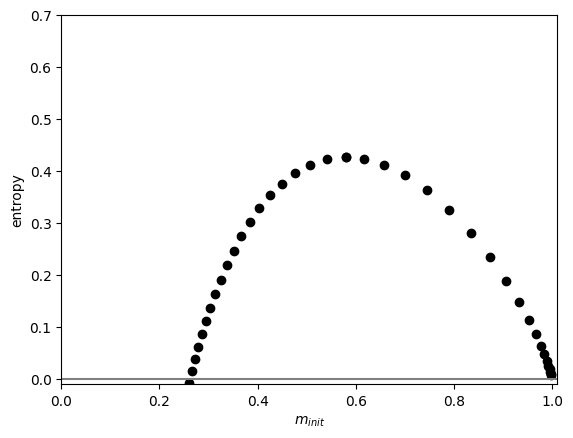

In [3]:
df_homogenous = load_pickle(path_homo)
plt.scatter(df_homogenous.m_init,df_homogenous.entropy,c='black',label='homogenous')
plt.axhline(0,c='grey')
plt.xlim(0,1.01)
plt.ylim(-0.01,0.7)
plt.xlabel('$m_{init}$')
plt.ylabel('entropy')

This plot gives us the entropy for the homogenous attractor.

### Partially Ratting Attractors

To run the BP for the partially rattling attractors we need to set $c=2$. However, any fixed point representing a homogenous attractor, i.e. $m_{init}=+1$ and $\rho=0.0$ can also be a fixed point of this dynamics.
We need to be careful to find the right one: When we run the naive version of the BP, we would only obtain the convex hull.
To obtain the plot from the paper, we adapt the temperature `m_init_temp` adaptively during the fixed point updates to give the target value `m_init`. In this way, we can slowly follow the fixed point from `m_init_temp=0.0` to other temperatures.

The following code demonstrates this.

> Since there is an extra optimization process running per iteration, this takes much longer than searching the homogenous attractor fixed points!

In [ ]:
# the results of this cell are precomputed. You may skip to the next cell.

results = []
for i, m_init in enumerate(np.linspace(0,1,20)):
    res_1 = run_bdcm(its=its, 
                         alpha=alpha, 
                         rule=rule, 
                         fix_observable=('m_init',m_init),
                         c=2,
                         d=d,
                         p=p,
                         init_func=init_balanced if i == 0 else lambda x: init_fixed(x,last_chi),
                         epsilon=10e-5)
    results.append(res_1)
    # follow the fixed point in the landscape by initializing it at the previously found one
    last_chi = res_1['chi'] 

In [5]:
df_rattling = pd.DataFrame(results)
dump_pickle(df_homogenous,path_homo)

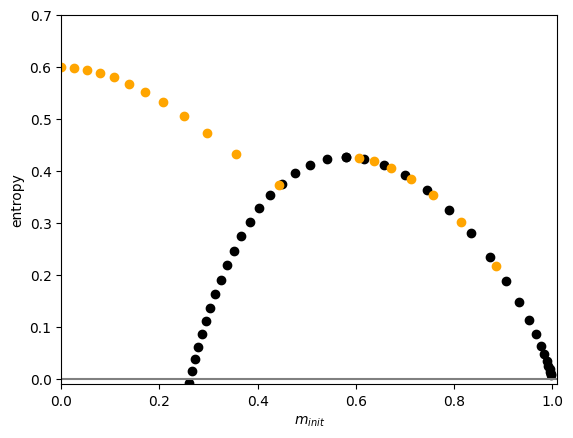

In [7]:
df_rattling = load_pickle(path_rattle)
plt.scatter(df_homogenous.m_init,df_homogenous.entropy,c='black',label='homogenous')
plt.scatter(df_rattling.m_init,df_rattling.entropy,c='orange',label='homogenous')
plt.axhline(0,c='grey')
plt.xlim(0,1.01)
plt.ylim(-0.01,0.7)
plt.xlabel('$m_{init}$')
plt.ylabel('entropy');

We observe that in the iterations for the partially ratting attractor fixed point jumps to the fixed point of the homogenous state. We can verify this, by checking the average magnetization in the attractor `mag_attr` and number of rattlers `rho`. They disappear once the 'line' of the homogenous attractor is joined.

## Comparison with empirics 

To compare our result with the empirics, we need to take into account that our BDCM prediction is only valid for $p=1$. To find an unbiased sample, we need to sample initial configurations with i.i.d. node states and condition on them reaching an attractor within 1 step.
It is almost impossible to find such inital configurations when sampling graphs with many nodes $n$. 
However, we can go really small: $n=15$.

In [ ]:
# the results of this cell are precomputed. You may skip to the next cell.

from src.empirics.simulation import simulate_varying_init
n = 30
rule='000111'
simulate_varying_init(rule, n,path=str(RESULT_DIR / f'application_B' / 'empirics'),
                      samples=100,buckets=80,n_start=15,n_end=n,record_energy=False,
                      random_model='networkx',
                      t_max=1)

In [ ]:
path = f'results/application_B/empirics'
results = flatten([load_pickle(f) for f in  Path(path).glob(f'*.pkl')])
df = pd.DataFrame(results)
df['m_init'] = df.density/df.n
df.m_init = df.m_init * 2 - 1
df['rho'] = df.rattlers / df.n
g = df.groupby('m_init').mean(numeric_only=True).reset_index()
df_empirics = g.copy()

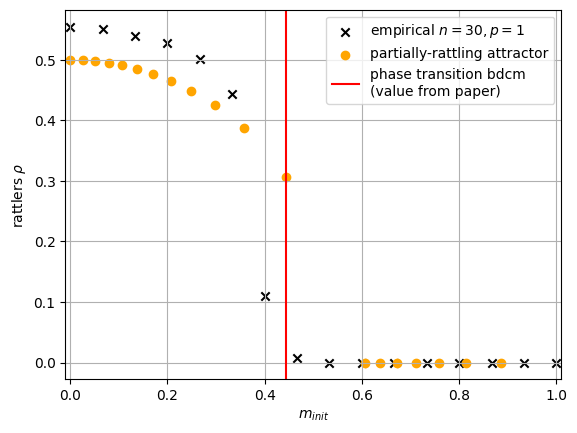

In [10]:
plt.scatter(g.m_init,g.rho,c='black',marker='x',label='empirical $n=30,p=1$')
plt.scatter(df_rattling.m_init,df_rattling.rho,c='orange',label='partially-rattling attractor')
plt.xlabel('$m_{init}$')
plt.ylabel(r'rattlers $\rho$')
plt.xlim(-0.01,1.01)
plt.axvline(0.443,c='red',label='phase transition bdcm \n(value from paper)')
plt.grid()
plt.legend();

Because $n$ is small, the discontinouity in $\rho$ is smoothed out significantly, we still see agreement.
In the paper we show a version of this plot where $p=4$ and $n=100$, showing a bit more beautiful agreement due to the larger size $n$.